In [2]:
import joblib
import pandas as pd
from datetime import datetime

from xgboost import XGBClassifier

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from yellowbrick.classifier import ROCAUC

from scipy.stats import ks_2samp

#### **Getting training && validation data**

In [3]:
df_train = pd.read_csv('../databases/training.csv')
X_train, y_train = df_train.drop(['IND_BOM_1_1'], axis=1), df_train['IND_BOM_1_1']

In [4]:
df_valid = pd.read_csv('../databases/validation.csv')
X_val, y_val = df_valid.drop(['IND_BOM_1_1'], axis=1), df_valid['IND_BOM_1_1']

#### **XGBoost Model**

In [5]:
model = XGBClassifier(n_estimators=100, n_jobs=-1)

In [6]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [8]:
today = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'./raw_models/model_{today}.pkl'

joblib.dump(model, filename)

['./raw_models/model_2023-04-05_23-45-05.pkl']

#### **Plots**

In [14]:
def plot_target_vs_score(target, scores, quantiles, lower_limit=None):
  eval_df = pd.DataFrame(zip(target, scores), columns=['TARGET', 'SCORE']).sort_values(by='SCORE')

  quantile = pd.qcut(eval_df['SCORE'], quantiles, labels=range(1,1+quantiles))
  eval_df['QUANTILE'] = quantile
  if lower_limit:
      eval_df = eval_df.loc[eval_df['QUANTILE'] > lower_limit]

  chart_df = pd.DataFrame(zip(
    eval_df.groupby('QUANTILE')['TARGET'].mean(), eval_df.groupby('QUANTILE')['TARGET'].size()/eval_df.shape[0]
    ), columns=['TAXA_DE_MAUS', 'POPULACAO'])

  fig = make_subplots(specs=[[{"secondary_y": True}]])

  chart_df = chart_df.dropna()
  
  fig.add_trace(
    go.Bar(x=chart_df.index.to_list(), y=chart_df.POPULACAO, name="Representativeness (%)", marker_color='rgba(0, 0, 87, .8)'),
    secondary_y=False,
  )

  fig.add_trace(
    go.Scatter(x=chart_df.index.to_list(), y=chart_df.TAXA_DE_MAUS, name="Weighted target mean by exposure (%)", marker_color='rgb(216, 125, 77)'),
    secondary_y=True,
    # labels=dict(x="Decil", y="Representativeness (%)")
  )

  fig.update_xaxes(title_text='Population Decile')
  fig.update_yaxes(title_text='Representativeness (%)', secondary_y=False)
  fig.update_yaxes(title_text='Weighted Target Mean by Exposure (%)', secondary_y=True)
  fig.update_layout(width=1000,height=500, legend=dict(orientation="h", xanchor='center', x=0.5, y=-0.2))

  fig.show()

#### **Model Evaluation**

In [15]:
y_pred = model.predict_proba(X_val)[:, 1]

##### KS and AUC analysis

In [16]:
ks_2samp(y_pred, y_val)

KstestResult(statistic=0.6554521742515669, pvalue=0.0, statistic_location=0.98813396692276, statistic_sign=1)

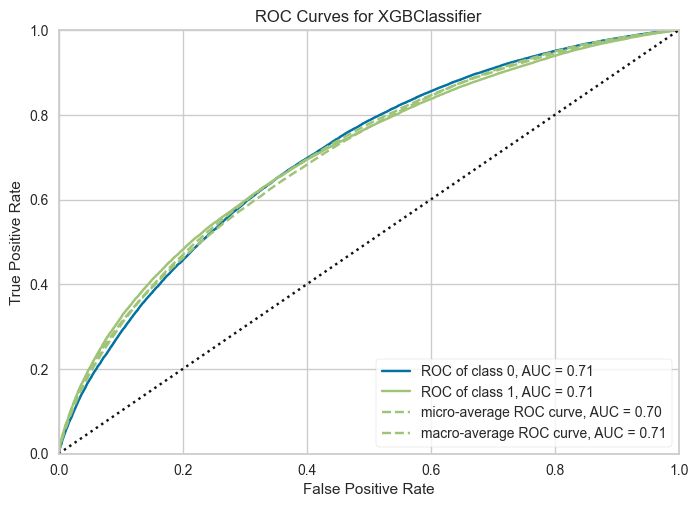

<Axes: title={'center': 'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [17]:
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)        
visualizer.score(X_val, y_val)    
visualizer.show()   

##### Target vs Score analysis

In [18]:
plot_target_vs_score(y_val, y_pred, quantiles=10)

In [19]:
plot_target_vs_score(y_val, y_pred, quantiles=100, lower_limit=90)